<a href="https://colab.research.google.com/github/Jaew00/DeepLearning/blob/main/%5B%EC%8B%A4%EC%8A%B504%5D_%EC%8B%AC%EC%B8%B5%EC%8B%A0%EA%B2%BD%EB%A7%9D_%ED%9B%88%EB%A0%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CIFAR10 을 CNN으로 학습하기. 여러 학습방법으로 비교

In [11]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt

from torch.optim import lr_scheduler

batch_size = 16
learning_rate = 0.002
num_epoch = 1

## 1. CIFAR10 train, test dataset 가져오기

In [3]:
cifar_train=dset.CIFAR10('CIFAR10/', train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
cifar_test=dset.CIFAR10('CIFAR10/', train=False, transform=transforms.ToTensor(), target_transform=None, download=True)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting CIFAR10/cifar-10-python.tar.gz to CIFAR10/
Files already downloaded and verified


## 2. 대략적인 데이터 형태

cfar_train 길이: 50000
cfar_test 길이: 10000
image data 형태: torch.Size([3, 32, 32])
label: 9


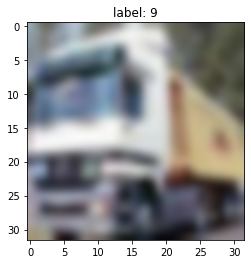

In [ ]:
print('cfar_train 길이:', len(cifar_train))
print('cfar_test 길이:', len(cifar_test))

# 데이터 하나 형태
image, label = cifar_train.__getitem__(1) # 1번째 데이터
print("image data 형태:", image.size())
print("label:", label)

# 그리기
img = image.numpy() # image 타입을 numpy로 변환(3, 32, 32)

# (3, 32, 32) -> (32, 32, 3)
r, g, b = img[0,:,:], img[1,:,:], img[2,:,:]
# img = img.reshape(img.shape[1], img.shape[2], img.shape[0])
img2 = np.zeros((img.shape[1], img.shape[2], img.shape[0]))
img2[:,:,0], img2[:,:,1], img2[:,:,2] = r, g, b

plt.title("label: %d" %label)
plt.imshow(img2, interpolation='bicubic')
plt.show()

In [4]:
def ComputeAccr(dloader, imodel):
  correct = 0
  total = 0

  for j, [imgs, labels] in enumerate(dloader) : # batch_size 만큼
    img = Variable(imgs, volatile = True).cuda() # x
    #label = Variable(labels) # y
    label = Variable(labels).cuda()

    output = imodel.forward(img)
    _, output_index = torch.max(output, 1)

    total += label.size(0)
    correct += (output_index == label).sum().float()

  print("Accuracy of Test Data: {}".format(100*correct/total))

## 3. 데이터 로드 함수

In [ ]:
train_loader = torch.utils.data.DataLoader(list(cifar_train)[:], batch_size = batch_size, shuffle = True,
                                           num_workers=2, drop_last = True)
test_loader = torch.utils.data.DataLoader(cifar_test, batch_size = batch_size, shuffle = False,
                                           num_workers=2, drop_last = True)

## 4. 모델 선언

In [ ]:
from torch.nn.modules.pooling import MaxPool2d
from torch.nn.modules.conv import Conv2d
class CNN(nn.Module) :
  def __init__(self) :
    super(CNN, self).__init__()
    self.layer = nn.Sequential(
        nn.Conv2d(3, 16, 3, padding=1),
        nn.ReLU(),
        #nn.Dropout2d(0, 2), #(2) drop out
        #nn.BatchNorm2d(16), #(6) Batch normalization
        nn.Conv2d(16, 32, 3, padding=1),
        nn.ReLU(),
        #nn.Dropout2d(0, 2),
        #nn.BatchNorm2d(32),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(32, 64, 3, padding=1),
        nn.ReLU(),
        #nn.Dropout2d(0,2),
        #nn.BatchNorm2d(64),
        nn.MaxPool2d(2, 2)
    )
    self.fc_layer=nn.Sequential(
        nn.Linear(64*8*8, 100),
        nn.ReLU(),
        #nn.Dropout2d(0, 2),
        #nn.BatchNorm2d(100),
        nn.Linear(100, 10)
    )

  def forward(self, x):
    out = self.layer(x)
    out = out.view(batch_size, -1)
    out = self.fc_layer(out)

    return out

model = CNN().cuda()

## 5. loss, optimizer

In [ ]:
loss_func=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate)

## 6. 학습

In [ ]:
for i in range(num_epoch):
  for j, [image, label] in enumerate(train_loader):
    x=Variable(image).cuda()
    y_=Variable(label).cuda()

    optimizer.zero_grad()
    output=model.forward(x)
    loss=loss_func(output,y_)
    loss.backward()
    optimizer.step()

    if j%1000==0:
      print(j, loss)

0 tensor(2.2860, device='cuda:0', grad_fn=<NllLossBackward0>)
1000 tensor(2.3014, device='cuda:0', grad_fn=<NllLossBackward0>)
2000 tensor(2.3232, device='cuda:0', grad_fn=<NllLossBackward0>)
3000 tensor(2.3021, device='cuda:0', grad_fn=<NllLossBackward0>)


## (0) Naive Test

In [ ]:
ComputeAccr(test_loader, model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 14.029999732971191


## (1) DropOut 

In [ ]:
from torch.nn.modules.pooling import MaxPool2d
from torch.nn.modules.conv import Conv2d
class CNN(nn.Module) :
  def __init__(self) :
    super(CNN, self).__init__()
    self.layer = nn.Sequential(
        nn.Conv2d(3, 16, 3, padding=1),
        nn.ReLU(),
        nn.Dropout2d(0.2), #(2) drop out
        #nn.BatchNorm2d(16), #(6) Batch normalization
        nn.Conv2d(16, 32, 3, padding=1),
        nn.ReLU(),
        nn.Dropout2d(0.2),
        #nn.BatchNorm2d(32),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(32, 64, 3, padding=1),
        nn.ReLU(),
        nn.Dropout2d(0.2),
        #nn.BatchNorm2d(64),
        nn.MaxPool2d(2, 2)
    )
    self.fc_layer=nn.Sequential(
        nn.Linear(64*8*8, 100),
        nn.ReLU(),
        nn.Dropout2d(0.2),
        #nn.BatchNorm2d(100),
        nn.Linear(100, 10)
    )

  def forward(self, x):
    out = self.layer(x)
    out = out.view(batch_size, -1)
    out = self.fc_layer(out)

    return out

model = CNN().cuda()

In [ ]:
for i in range(num_epoch):
  for j, [image, label] in enumerate(train_loader):
    x=Variable(image).cuda()
    y_=Variable(label).cuda()

    optimizer.zero_grad()
    output=model.forward(x)
    loss=loss_func(output,y_)
    loss.backward()
    optimizer.step()

    if j%1000==0:
      print(j, loss)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


0 tensor(2.3054, device='cuda:0', grad_fn=<NllLossBackward0>)
1000 tensor(2.2920, device='cuda:0', grad_fn=<NllLossBackward0>)
2000 tensor(2.2868, device='cuda:0', grad_fn=<NllLossBackward0>)
3000 tensor(2.2911, device='cuda:0', grad_fn=<NllLossBackward0>)


In [ ]:
ComputeAccr(test_loader, model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Accuracy of Test Data: 10.579999923706055


## (2) Data Augmentation

In [ ]:
cifar_train=dset.CIFAR10('CIFAR10/', train=True,
                         transform=transforms.Compose([
                          transforms.Resize(36),
                          transforms.CenterCrop(32),
                          transforms.RandomHorizontalFlip(),
                          transforms.Lambda(lambda x : x.rotate(90)),
                          transforms.ToTensor()
                         ]))
cifar_test=dset.CIFAR10('CIFAR10/', train=False, transform=transforms.ToTensor(), target_transform=None, download=True)


Files already downloaded and verified


cfar_train 길이: 50000
cfar_test 길이: 10000
image data 형태: torch.Size([3, 32, 32])
label: 9


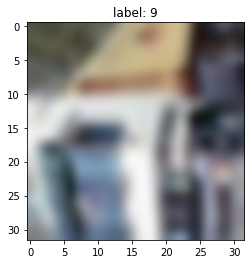

In [ ]:
print('cfar_train 길이:', len(cifar_train))
print('cfar_test 길이:', len(cifar_test))

# 데이터 하나 형태
image, label = cifar_train.__getitem__(1) # 1번째 데이터
print("image data 형태:", image.size())
print("label:", label)

# 그리기
img = image.numpy() # image 타입을 numpy로 변환(3, 32, 32)

# (3, 32, 32) -> (32, 32, 3)
r, g, b = img[0,:,:], img[1,:,:], img[2,:,:]
# img = img.reshape(img.shape[1], img.shape[2], img.shape[0])
img2 = np.zeros((img.shape[1], img.shape[2], img.shape[0]))
img2[:,:,0], img2[:,:,1], img2[:,:,2] = r, g, b

plt.title("label: %d" %label)
plt.imshow(img2, interpolation='bicubic')
plt.show()

In [ ]:
train_loader = torch.utils.data.DataLoader(list(cifar_train)[:], batch_size = batch_size, shuffle = True,
                                           num_workers=2, drop_last = True)
test_loader = torch.utils.data.DataLoader(cifar_test, batch_size = batch_size, shuffle = False,
                                           num_workers=2, drop_last = True)

In [ ]:
from torch.nn.modules.pooling import MaxPool2d
from torch.nn.modules.conv import Conv2d
class CNN(nn.Module) :
  def __init__(self) :
    super(CNN, self).__init__()
    self.layer = nn.Sequential(
        nn.Conv2d(3, 16, 3, padding=1),
        nn.ReLU(),
        #nn.Dropout2d(0, 2), #(2) drop out
        #nn.BatchNorm2d(16), #(6) Batch normalization
        nn.Conv2d(16, 32, 3, padding=1),
        nn.ReLU(),
        #nn.Dropout2d(0, 2),
        #nn.BatchNorm2d(32),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(32, 64, 3, padding=1),
        nn.ReLU(),
        #nn.Dropout2d(0,2),
        #nn.BatchNorm2d(64),
        nn.MaxPool2d(2, 2)
    )
    self.fc_layer=nn.Sequential(
        nn.Linear(64*8*8, 100),
        nn.ReLU(),
        #nn.Dropout2d(0, 2),
        #nn.BatchNorm2d(100),
        nn.Linear(100, 10)
    )

  def forward(self, x):
    out = self.layer(x)
    out = out.view(batch_size, -1)
    out = self.fc_layer(out)

    return out

model = CNN().cuda()

In [ ]:
for i in range(num_epoch):
  for j, [image, label] in enumerate(train_loader):
    x=Variable(image).cuda()
    y_=Variable(label).cuda()

    optimizer.zero_grad()
    output=model.forward(x)
    loss=loss_func(output,y_)
    loss.backward()
    optimizer.step()

    if j%1000==0:
      print(j, loss)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


0 tensor(2.3090, device='cuda:0', grad_fn=<NllLossBackward0>)
1000 tensor(2.3236, device='cuda:0', grad_fn=<NllLossBackward0>)
2000 tensor(2.3205, device='cuda:0', grad_fn=<NllLossBackward0>)
3000 tensor(2.3055, device='cuda:0', grad_fn=<NllLossBackward0>)


In [ ]:
ComputeAccr(test_loader, model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Accuracy of Test Data: 10.429999351501465


## (3) Wieght Initialization

In [ ]:
cifar_train=dset.CIFAR10('CIFAR10/', train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
cifar_test=dset.CIFAR10('CIFAR10/', train=False, transform=transforms.ToTensor(), target_transform=None, download=True)


Files already downloaded and verified
Files already downloaded and verified


cfar_train 길이: 50000
cfar_test 길이: 10000
image data 형태: torch.Size([3, 32, 32])
label: 9


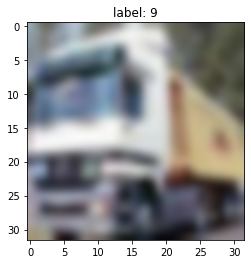

In [ ]:
print('cfar_train 길이:', len(cifar_train))
print('cfar_test 길이:', len(cifar_test))

# 데이터 하나 형태
image, label = cifar_train.__getitem__(1) # 1번째 데이터
print("image data 형태:", image.size())
print("label:", label)

# 그리기
img = image.numpy() # image 타입을 numpy로 변환(3, 32, 32)

# (3, 32, 32) -> (32, 32, 3)
r, g, b = img[0,:,:], img[1,:,:], img[2,:,:]
# img = img.reshape(img.shape[1], img.shape[2], img.shape[0])
img2 = np.zeros((img.shape[1], img.shape[2], img.shape[0]))
img2[:,:,0], img2[:,:,1], img2[:,:,2] = r, g, b

plt.title("label: %d" %label)
plt.imshow(img2, interpolation='bicubic')
plt.show()

In [ ]:
train_loader = torch.utils.data.DataLoader(list(cifar_train)[:], batch_size = batch_size, shuffle = True,
                                           num_workers=2, drop_last = True)
test_loader = torch.utils.data.DataLoader(cifar_test, batch_size = batch_size, shuffle = False,
                                           num_workers=2, drop_last = True)

In [ ]:
from torch.nn.modules.pooling import MaxPool2d
from torch.nn.modules.conv import Conv2d
class CNN(nn.Module) :
  def __init__(self) :
    super(CNN, self).__init__()
    self.layer = nn.Sequential(
        nn.Conv2d(3, 16, 3, padding=1),
        nn.ReLU(),
        #nn.Dropout2d(0, 2), #(2) drop out
        #nn.BatchNorm2d(16), #(6) Batch normalization
        nn.Conv2d(16, 32, 3, padding=1),
        nn.ReLU(),
        #nn.Dropout2d(0, 2),
        #nn.BatchNorm2d(32),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(32, 64, 3, padding=1),
        nn.ReLU(),
        #nn.Dropout2d(0,2),
        #nn.BatchNorm2d(64),
        nn.MaxPool2d(2, 2)
    )
    self.fc_layer=nn.Sequential(
        nn.Linear(64*8*8, 100),
        nn.ReLU(),
        #nn.Dropout2d(0, 2),
        #nn.BatchNorm2d(100),
        nn.Linear(100, 10)
    )

    #(3) weight initialization
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
          init.kaiming_normal_(m.weight.data) # ReUL일 때
          m.bias.data.fill_(0)
      if isinstance(m, nn.Linear):
          init.kaiming_normal_(m.weight.data)
          m.bias.data.fill_(0)


  def forward(self, x):
    out = self.layer(x)
    out = out.view(batch_size, -1)
    out = self.fc_layer(out)

    return out

model = CNN().cuda()

In [ ]:
for i in range(num_epoch):
  for j, [image, label] in enumerate(train_loader):
    x=Variable(image).cuda()
    y_=Variable(label).cuda()

    optimizer.zero_grad()
    output=model.forward(x)
    loss=loss_func(output,y_)
    loss.backward()
    optimizer.step()

    if j%1000==0:
      print(j, loss)

0 tensor(2.3348, device='cuda:0', grad_fn=<NllLossBackward0>)
1000 tensor(2.4375, device='cuda:0', grad_fn=<NllLossBackward0>)
2000 tensor(2.4356, device='cuda:0', grad_fn=<NllLossBackward0>)
3000 tensor(2.3465, device='cuda:0', grad_fn=<NllLossBackward0>)


In [ ]:
ComputeAccr(test_loader, model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 10.469999313354492


## (4) Data Normalization

In [5]:
cifar_train=dset.CIFAR10('CIFAR10/', train=True,
                         transform=transforms.Compose([
                          transforms.ToTensor(),
                          transforms.Normalize(mean=(0.5, 0.5, 0.5),std=(0.5, 0.5, 0.5)),
                         ]),
                         target_transform=None, download=False)

cifar_test=dset.CIFAR10('CIFAR10/', train=False,
                         transform=transforms.Compose([
                          transforms.ToTensor(),
                          transforms.Normalize(mean=(0.5, 0.5, 0.5),std=(0.5, 0.5, 0.5)),
                         ]),
                         target_transform=None, download=False)


In [6]:
train_loader = torch.utils.data.DataLoader(list(cifar_train)[:], batch_size = batch_size, shuffle = True,
                                           num_workers=2, drop_last = True)
test_loader = torch.utils.data.DataLoader(cifar_test, batch_size = batch_size, shuffle = False,
                                           num_workers=2, drop_last = True)


from torch.nn.modules.pooling import MaxPool2d
from torch.nn.modules.conv import Conv2d
class CNN(nn.Module) :
  def __init__(self) :
    super(CNN, self).__init__()
    self.layer = nn.Sequential(
        nn.Conv2d(3, 16, 3, padding=1),
        nn.ReLU(),
        #nn.Dropout2d(0, 2), #(2) drop out
        #nn.BatchNorm2d(16), #(6) Batch normalization
        nn.Conv2d(16, 32, 3, padding=1),
        nn.ReLU(),
        #nn.Dropout2d(0, 2),
        #nn.BatchNorm2d(32),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(32, 64, 3, padding=1),
        nn.ReLU(),
        #nn.Dropout2d(0,2),
        #nn.BatchNorm2d(64),
        nn.MaxPool2d(2, 2)
    )
    self.fc_layer=nn.Sequential(
        nn.Linear(64*8*8, 100),
        nn.ReLU(),
        #nn.Dropout2d(0, 2),
        #nn.BatchNorm2d(100),
        nn.Linear(100, 10)
    )

  def forward(self, x):
    out = self.layer(x)
    out = out.view(batch_size, -1)
    out = self.fc_layer(out)

    return out

model = CNN().cuda()

loss_func=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate)

for i in range(num_epoch):
  for j, [image, label] in enumerate(train_loader):
    x=Variable(image).cuda()
    y_=Variable(label).cuda()

    optimizer.zero_grad()
    output=model.forward(x)
    loss=loss_func(output,y_)
    loss.backward()
    optimizer.step()

    if j%1000==0:
      print(j, loss)

ComputeAccr(test_loader, model)

0 tensor(2.2767, device='cuda:0', grad_fn=<NllLossBackward0>)
1000 tensor(2.3152, device='cuda:0', grad_fn=<NllLossBackward0>)
2000 tensor(2.3087, device='cuda:0', grad_fn=<NllLossBackward0>)
3000 tensor(2.2577, device='cuda:0', grad_fn=<NllLossBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 20.69999885559082


## (5) Batch Normalization

In [8]:
cifar_train=dset.CIFAR10('CIFAR10/', train=True, 
                         transform=transforms.ToTensor(), target_transform=None, download=True)
cifar_test=dset.CIFAR10('CIFAR10/', train=False, 
                        transform=transforms.ToTensor(), target_transform=None, download=True)


train_loader = torch.utils.data.DataLoader(list(cifar_train)[:], batch_size = batch_size, shuffle = True,
                                           num_workers=2, drop_last = True)
test_loader = torch.utils.data.DataLoader(cifar_test, batch_size = batch_size, shuffle = False,
                                           num_workers=2, drop_last = True)


from torch.nn.modules.pooling import MaxPool2d
from torch.nn.modules.conv import Conv2d
class CNN(nn.Module) :
  def __init__(self) :
    super(CNN, self).__init__()
    self.layer = nn.Sequential(
        nn.Conv2d(3, 16, 3, padding=1),
        nn.ReLU(),
        #nn.Dropout2d(0, 2), #(2) drop out
        nn.BatchNorm2d(16), #(5) Batch normalization
        nn.Conv2d(16, 32, 3, padding=1),
        nn.ReLU(),
        #nn.Dropout2d(0, 2),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(32, 64, 3, padding=1),
        nn.ReLU(),
        #nn.Dropout2d(0,2),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(2, 2)
    )
    self.fc_layer=nn.Sequential(
        nn.Linear(64*8*8, 100),
        nn.ReLU(),
        #nn.Dropout2d(0, 2),
        nn.BatchNorm1d(100),
        nn.Linear(100, 10)
    )

  def forward(self, x):
    out = self.layer(x)
    out = out.view(batch_size, -1)
    out = self.fc_layer(out)

    return out

model = CNN().cuda()

loss_func=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate)

for i in range(num_epoch):
  for j, [image, label] in enumerate(train_loader):
    x=Variable(image).cuda()
    y_=Variable(label).cuda()

    optimizer.zero_grad()
    output=model.forward(x)
    loss=loss_func(output,y_)
    loss.backward()
    optimizer.step()

    if j%1000==0:
      print(j, loss)

ComputeAccr(test_loader, model)

Files already downloaded and verified
Files already downloaded and verified
0 tensor(2.2231, device='cuda:0', grad_fn=<NllLossBackward0>)
1000 tensor(1.7882, device='cuda:0', grad_fn=<NllLossBackward0>)
2000 tensor(1.6664, device='cuda:0', grad_fn=<NllLossBackward0>)
3000 tensor(1.3052, device='cuda:0', grad_fn=<NllLossBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 61.31999969482422


## (6) Adam Optimizer

In [9]:
cifar_train=dset.CIFAR10('CIFAR10/', train=True, 
                         transform=transforms.ToTensor(), target_transform=None, download=True)
cifar_test=dset.CIFAR10('CIFAR10/', train=False, 
                        transform=transforms.ToTensor(), target_transform=None, download=True)

train_loader = torch.utils.data.DataLoader(list(cifar_train)[:], batch_size = batch_size, shuffle = True,
                                           num_workers=2, drop_last = True)
test_loader = torch.utils.data.DataLoader(cifar_test, batch_size = batch_size, shuffle = False,
                                           num_workers=2, drop_last = True)


from torch.nn.modules.pooling import MaxPool2d
from torch.nn.modules.conv import Conv2d
class CNN(nn.Module) :
  def __init__(self) :
    super(CNN, self).__init__()
    self.layer = nn.Sequential(
        nn.Conv2d(3, 16, 3, padding=1),
        nn.ReLU(),
        #nn.Dropout2d(0, 2), #(2) drop out
        #nn.BatchNorm2d(16), #(6) Batch normalization
        nn.Conv2d(16, 32, 3, padding=1),
        nn.ReLU(),
        #nn.Dropout2d(0, 2),
        #nn.BatchNorm2d(32),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(32, 64, 3, padding=1),
        nn.ReLU(),
        #nn.Dropout2d(0,2),
        #nn.BatchNorm2d(64),
        nn.MaxPool2d(2, 2)
    )
    self.fc_layer=nn.Sequential(
        nn.Linear(64*8*8, 100),
        nn.ReLU(),
        #nn.Dropout2d(0, 2),
        #nn.BatchNorm2d(100),
        nn.Linear(100, 10)
    )

  def forward(self, x):
    out = self.layer(x)
    out = out.view(batch_size, -1)
    out = self.fc_layer(out)

    return out

model = CNN().cuda()

# ===== 5. loss, optimizer =====
loss_func=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)

for i in range(num_epoch):
  for j, [image, label] in enumerate(train_loader):
    x=Variable(image).cuda()
    y_=Variable(label).cuda()

    optimizer.zero_grad()
    output=model.forward(x)
    loss=loss_func(output,y_)
    loss.backward()
    optimizer.step()

    if j%1000==0:
      print(j, loss)

ComputeAccr(test_loader, model)

Files already downloaded and verified
Files already downloaded and verified
0 tensor(2.3014, device='cuda:0', grad_fn=<NllLossBackward0>)
1000 tensor(1.4263, device='cuda:0', grad_fn=<NllLossBackward0>)
2000 tensor(1.2307, device='cuda:0', grad_fn=<NllLossBackward0>)
3000 tensor(0.7115, device='cuda:0', grad_fn=<NllLossBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 57.55999755859375


## (7) learning rate decay

In [12]:
num_epoch = 60

cifar_train=dset.CIFAR10('CIFAR10/', train=True, 
                         transform=transforms.ToTensor(), target_transform=None, download=True)
cifar_test=dset.CIFAR10('CIFAR10/', train=False, 
                        transform=transforms.ToTensor(), target_transform=None, download=True)

train_loader = torch.utils.data.DataLoader(list(cifar_train)[:], batch_size = batch_size, shuffle = True,
                                           num_workers=2, drop_last = True)
test_loader = torch.utils.data.DataLoader(cifar_test, batch_size = batch_size, shuffle = False,
                                           num_workers=2, drop_last = True)


from torch.nn.modules.pooling import MaxPool2d
from torch.nn.modules.conv import Conv2d
class CNN(nn.Module) :
  def __init__(self) :
    super(CNN, self).__init__()
    self.layer = nn.Sequential(
        nn.Conv2d(3, 16, 3, padding=1),
        nn.ReLU(),
        #nn.Dropout2d(0, 2), #(2) drop out
        #nn.BatchNorm2d(16), #(6) Batch normalization
        nn.Conv2d(16, 32, 3, padding=1),
        nn.ReLU(),
        #nn.Dropout2d(0, 2),
        #nn.BatchNorm2d(32),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(32, 64, 3, padding=1),
        nn.ReLU(),
        #nn.Dropout2d(0,2),
        #nn.BatchNorm2d(64),
        nn.MaxPool2d(2, 2)
    )
    self.fc_layer=nn.Sequential(
        nn.Linear(64*8*8, 100),
        nn.ReLU(),
        #nn.Dropout2d(0, 2),
        #nn.BatchNorm2d(100),
        nn.Linear(100, 10)
    )

  def forward(self, x):
    out = self.layer(x)
    out = out.view(batch_size, -1)
    out = self.fc_layer(out)

    return out

model = CNN().cuda()

loss_func=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate)

scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.2) # 7. learning rate decay

for i in range(num_epoch):
  for j, [image, label] in enumerate(train_loader):
    x=Variable(image).cuda()
    y_=Variable(label).cuda()

    optimizer.zero_grad()
    output=model.forward(x)
    loss=loss_func(output,y_)
    loss.backward()
    optimizer.step()

    if j%1000==0:
      print(j, loss)

ComputeAccr(test_loader, model)

Files already downloaded and verified
Files already downloaded and verified
0 tensor(2.2980, device='cuda:0', grad_fn=<NllLossBackward0>)
1000 tensor(2.2968, device='cuda:0', grad_fn=<NllLossBackward0>)
2000 tensor(2.2715, device='cuda:0', grad_fn=<NllLossBackward0>)
3000 tensor(2.2080, device='cuda:0', grad_fn=<NllLossBackward0>)
0 tensor(2.0974, device='cuda:0', grad_fn=<NllLossBackward0>)
1000 tensor(2.0151, device='cuda:0', grad_fn=<NllLossBackward0>)
2000 tensor(2.1366, device='cuda:0', grad_fn=<NllLossBackward0>)
3000 tensor(1.9353, device='cuda:0', grad_fn=<NllLossBackward0>)
0 tensor(2.0604, device='cuda:0', grad_fn=<NllLossBackward0>)
1000 tensor(1.9702, device='cuda:0', grad_fn=<NllLossBackward0>)
2000 tensor(2.0257, device='cuda:0', grad_fn=<NllLossBackward0>)
3000 tensor(1.7058, device='cuda:0', grad_fn=<NllLossBackward0>)
0 tensor(1.9715, device='cuda:0', grad_fn=<NllLossBackward0>)
1000 tensor(1.3509, device='cuda:0', grad_fn=<NllLossBackward0>)
2000 tensor(1.9155, device

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Accuracy of Test Data: 64.72000122070312
